In [173]:
data_dir = '/Users/peterwills/google-drive/python/entelligent/data/'
risk_free_rate = 0.0008295381 # from Mark L.
spy_asset_ret = pd.read_pickle(os.path.join(data_dir,'interim/historical/sp500/spy_ret_m.p'))

def strip_list(string_list):
    striped_list = []
    for string in string_list:
        stripped = string.split('-US')[0]
        striped_list.append(stripped)
    return striped_list

def make_unique(df,col='Date'):
    grouped_dfs = df.groupby('Ticker')
    df_list = []
    for group in grouped_dfs:
        name = group[0]
        df = group[1]
        df = df.drop_duplicates(subset=col)
        df_list.append(df)
    return pd.concat(df_list)

In [174]:
years = range(2000,2018)
spy_asset_ret.index = pd.to_datetime(spy_asset_ret.index)
returns = (spy_asset_ret+1).pct_change()
returns = returns[returns.index.year>2000].dropna(axis=1)

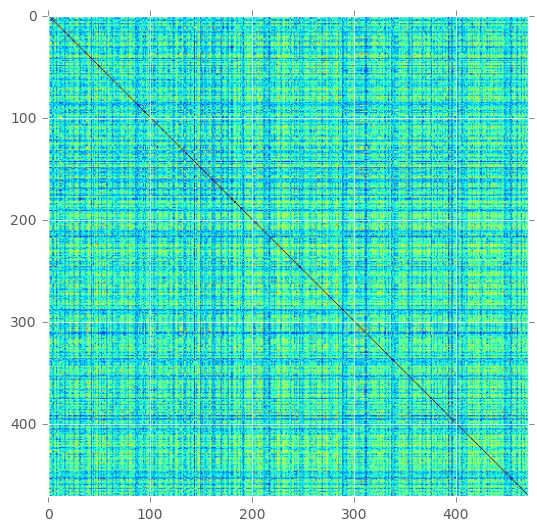

In [175]:
total_cov = np.corrcoef(returns,rowvar=False)
plt.imshow(total_cov)

# make graphs

In [74]:
amats = []
T = 0

for year in range(2006,2018):
    year_returns = returns[returns.index.year == year]
    graph = np.corrcoef(year_returns,rowvar=False)
    graph = graph - np.diag(np.diag(graph)) # kill diagonal
    graph = np.abs(graph)
#     graph = graph / graph.max()
#     masked = np.where(graph > T, graph, np.zeros(graph.shape))
    amats.append(np.matrix(graph))

In [75]:
%%time

import netcomp as nc

r_dists = []
e_dists = []
d_dists = []
ns_dists = []
adj_dists = []
lap_dists = []
nlap_dists = []

year = 2006

for A_old,A in zip(amats[:-1],amats[1:]):
    print('Processing year {}.'.format(year))
    year += 1
    r_dists.append(nc.resistance_distance(A,A_old,renormalized=True))
    e_dists.append(nc.edit_distance(A,A_old))
    d_dists.append(nc.deltacon0(A,A_old))
#     ns_dists.append(nc.netsimile(A,A_old))
    adj_dists.append(nc.lambda_dist(A,A_old,kind='adjacency'))
    lap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian'))
    nlap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian_norm'))

Processing year 2006.
Processing year 2007.
Processing year 2008.
Processing year 2009.
Processing year 2010.
Processing year 2011.
Processing year 2012.
Processing year 2013.
Processing year 2014.
Processing year 2015.
Processing year 2016.
CPU times: user 2min 41s, sys: 7.08 s, total: 2min 48s
Wall time: 2min 47s


In [76]:
# normalize by sample mean
r_dists = r_dists/np.mean(r_dists)
e_dists = e_dists/np.mean(e_dists)
d_dists = d_dists/np.mean(d_dists)
# ns_dists = ns_dists/np.mean(ns_dists)
adj_dists = adj_dists/np.mean(adj_dists)
lap_dists = lap_dists/np.mean(lap_dists)
nlap_dists = nlap_dists/np.mean(nlap_dists)

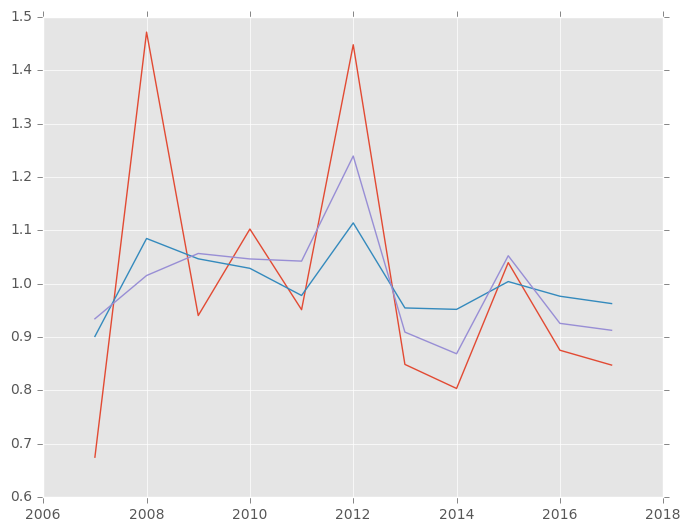

In [77]:
# plot curves
plt.plot(range(2007,2018),r_dists,label='$\widehat{D}_R(t)$');
plt.plot(range(2007,2018),e_dists,label='$\widehat{D}_E(t)$');
plt.plot(range(2007,2018),d_dists,label='$\widehat{D}_{DC}(t)$');

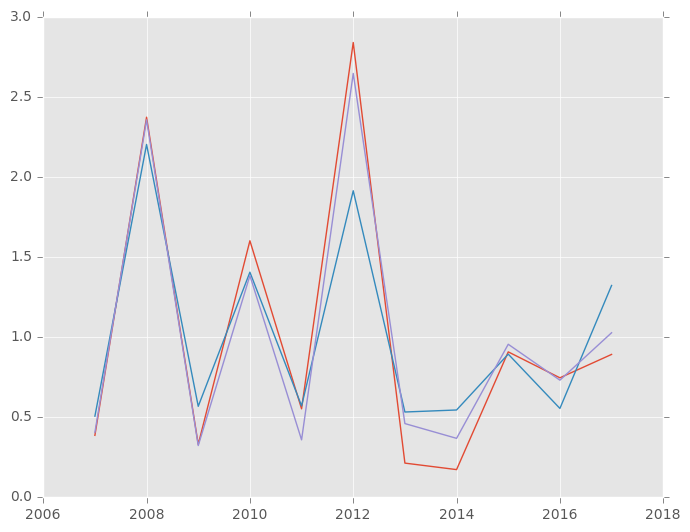

In [78]:
# plot curves
plt.plot(range(2007,2018),lap_dists,label='$\widehat{D}_{L}(t)$');
plt.plot(range(2007,2018),nlap_dists,label='$\widehat{D}_{\mathcal{L}}(t)$');
plt.plot(range(2007,2018),adj_dists,label='$\widehat{D}_{A}(t)$');

Okay, this doens't look very good. Let's try sorting by market cap.

In [195]:
market_cap = pd.read_csv('/Users/peterwills/google-drive/python/entelligent/data/raw/FactSet' \
                         + '/sp500YearlyMarketCap.csv')

market_cap['Year'] = [date.year for date in pd.to_datetime(market_cap['Date'])]
del market_cap['Date']
market_cap = make_unique(market_cap,col='Year')
market_cap.set_index('Year',inplace=True)
market_cap = market_cap.pivot(columns='Ticker')['Market Cap']
market_cap = market_cap.T
market_cap.index = strip_list(market_cap.index)

In [196]:
years = range(2000,2018)

returns = (spy_asset_ret+1).pct_change()
returns = returns[returns.index.year >= 2000].dropna(axis=1)

mean_mcs = market_cap.mean(axis=1)
sorted_mcs = mean_mcs.sort_values(ascending=False)
shared_tickers = sorted_mcs.index.intersection(returns.columns) # still sorted by MC

## Make graphs

In [210]:
amats = []
T = 0.3
N = 50
tickers = shared_tickers[:N]

for year in years:
    year_returns = returns[returns.index.year == year]
    graph = np.corrcoef(year_returns[tickers],rowvar=False)
    graph = graph - np.diag(np.diag(graph)) # kill diagonal
    graph = np.abs(graph)
    graph = graph / graph.max()
    masked = np.where(graph > T, graph, np.zeros(graph.shape))
    amats.append(np.matrix(masked))

In [211]:
%%time

import netcomp as nc

r_dists = []
e_dists = []
d_dists = []
ns_dists = []
adj_dists = []
lap_dists = []
nlap_dists = []

for A_old,A in zip(amats[:-1],amats[1:]):
#     print('Processing year {}.'.format(year))
#     year += 1
    r_dists.append(nc.resistance_distance(A,A_old,renormalized=True))
    e_dists.append(nc.edit_distance(A,A_old))
    d_dists.append(nc.deltacon0(A,A_old))
#     ns_dists.append(nc.netsimile(A,A_old))
    adj_dists.append(nc.lambda_dist(A,A_old,kind='adjacency'))
    lap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian'))
    nlap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian_norm'))

CPU times: user 1.19 s, sys: 9.63 ms, total: 1.2 s
Wall time: 1.2 s


In [212]:
# normalize by sample mean
r_dists = r_dists/np.mean(r_dists)
e_dists = e_dists/np.mean(e_dists)
d_dists = d_dists/np.mean(d_dists)
# ns_dists = ns_dists/np.mean(ns_dists)
adj_dists = adj_dists/np.mean(adj_dists)
lap_dists = lap_dists/np.mean(lap_dists)
nlap_dists = nlap_dists/np.mean(nlap_dists)

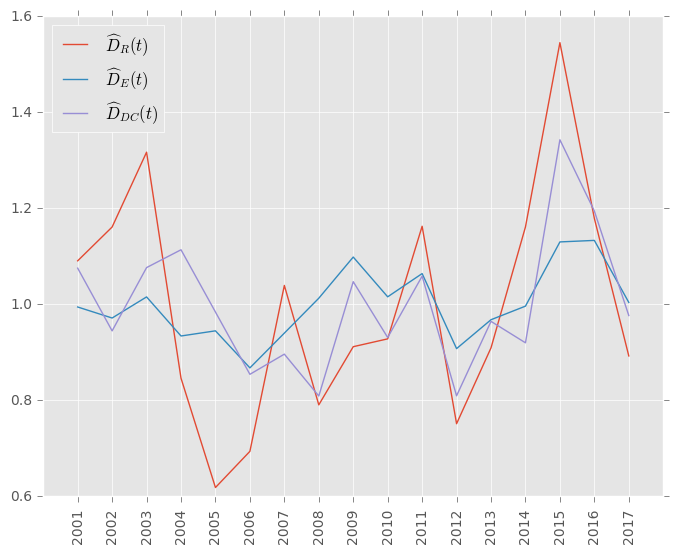

In [213]:
# plot curves
plt.plot(years[1:],r_dists,label='$\widehat{D}_R(t)$');
plt.plot(years[1:],e_dists,label='$\widehat{D}_E(t)$');
plt.plot(years[1:],d_dists,label='$\widehat{D}_{DC}(t)$');
plt.xticks(years[1:],rotation=90);
plt.legend();

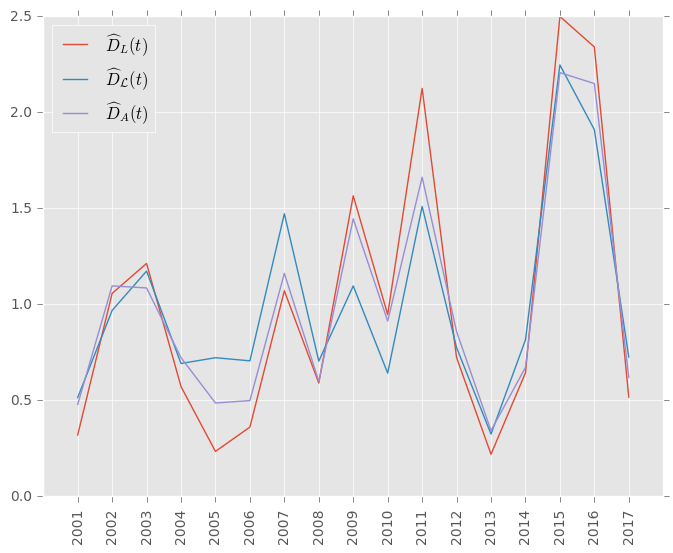

In [214]:
# plot curves
plt.plot(years[1:],lap_dists,label='$\widehat{D}_{L}(t)$');
plt.plot(years[1:],nlap_dists,label='$\widehat{D}_{\mathcal{L}}(t)$');
plt.plot(years[1:],adj_dists,label='$\widehat{D}_{A}(t)$');
plt.xticks(years[1:],rotation=90);
plt.legend();